In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [2]:
N = 7; k_B = 1; temp = 5e-1; ts = np.linspace(0, 10,750)
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: True


In [3]:
rhos = []
    
def callback(t, rhot):
    #global rho
    global rhos
    rho = rhot
    rhos.append(rhot)
    
    rhos = []    
    def callbacks(t, rhot):
        global rho
        global rhos
        rho = rhot
        rhos.append(rhot)

def exact_evolution(Hamiltonian, rho0, ts, obs):
    approx_exp_vals = []
    for t in ts:
        qutip.mesolve(Hamiltonian, rho0=rho0, tlist=np.linspace(t-1,t,1), c_ops=None, e_ops=callback)
        #newobs = [qutip.expect(rho, op) for op in obs]
        #approx_exp_vals.append(newobs)
    result = {}
    result["times"] = ts
    #result["averages"] = np.array(approx_exp_vals)
    result["state ev"] = rhos
    return result

In [4]:
def d_depth_proj_ev(initial_d_list, seed_ops_list, size, Hamiltonian, cl_ops_list, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(size = size, temp = temp, Hamiltonian = Hamiltonian,
                                       lagrange_op = cl_ops["n_oc_op"], lagrange_mult = .1, svd = True)
    basis_incursive = me.vectorized_recursive_basis(depth_list = initial_d_list, 
                                                    seed_ops_list = seed_ops_list,
                                                    Hamiltonian = Hamiltonian, rho0 = rho_ref)
    basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False)
    
    ### test 2
    basis_orth, gram_matrix = me.basis_orthonormality_check(basis = basis_orth, 
                                                            rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth)
    Hijtensor = qutip.Qobj(me.H_ij_matrix(Hamiltonian = Hamiltonian, basis = basis_orth, 
                                           rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)[1])
    if visualize_H_evs: 
        me.visz_H_tensor_evs(Htensor = Hijtensor)
        
    ### constructing the coefficient arrays and the physical states
    rhot_list = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, Htensor = Hijtensor,
                                               ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
                                            visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in herm_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    #res_exact = exact_evolution(Hamiltonian, rho0, ts, observables)
    #res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops = observables)
    
    res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=observables)
    res_exact_B = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=None)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        label = ["x_op", "n_oc_op", "magnetization"]
        me.plot_exact_v_proj_ev_avgs(observables, label, ts, res_proj_ev, res_exact)
        
    #max_diff_x = max(res_exact["averages"][:,0][:-1] - res_proj_ev[0])
    #max_diff_n_oc = max(res_exact["averages"][:,1][:-1] - res_proj_ev[1])
    #print(max_diff_x, max_diff_n_oc)
    
    if True:
        bures_exact_approx_list = [me.bures(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list = [me.rel_entropy(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list_prime = [me.rel_entropy(res_exact_B.states[t], herm_rhot_list[t]) for t in range(len(herm_rhot_list))]
        fig6, ax6 = plt.subplots()
        ax6.plot(ts[:-1], bures_exact_approx_list, label = "Bures metric")
        ax6.plot(ts[:-1], relentropy_exact_approx_list, label = "Relative entropy - Proj. v. Exact")
        ax6.plot(ts[:-1], relentropy_exact_approx_list_prime, label = "Relative entropy - Exact v. Proj.")
        ax6.legend(loc=0)
        ax6.set_title("Metrics - Exact and Proj. ev")
    
    return rho0, herm_rhot_list, res_exact, res_exact_B, res_proj_ev

The 3 -th operator is not normalized 

The 7 -th operator is not normalized 

The basis is orthonormal and hermitian
rho0: not positive defined
Proj ev runtime =  683.771502494812
Exact ev runtime =  10.505121231079102


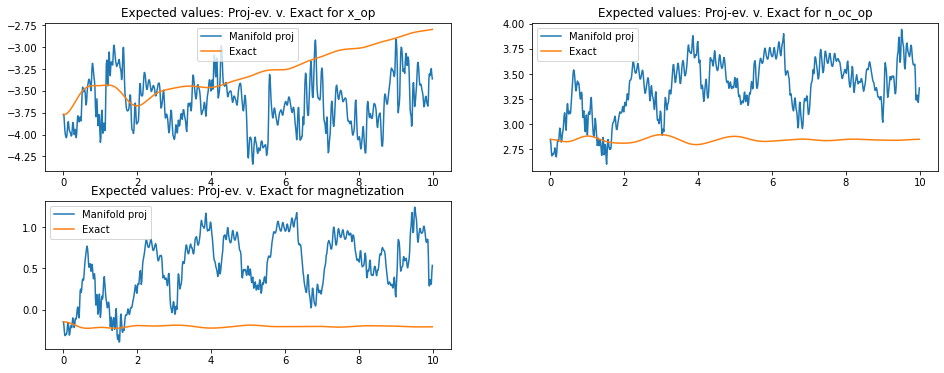

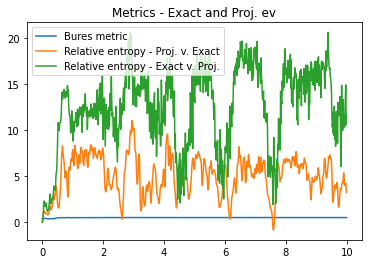

In [6]:
initial_d_list = [0, 5, 5, 50]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

The 3 -th operator is not normalized 

The basis is orthonormal and hermitian
rho0: not positive defined
Proj ev runtime =  722.307651758194
Exact ev runtime =  10.141750574111938


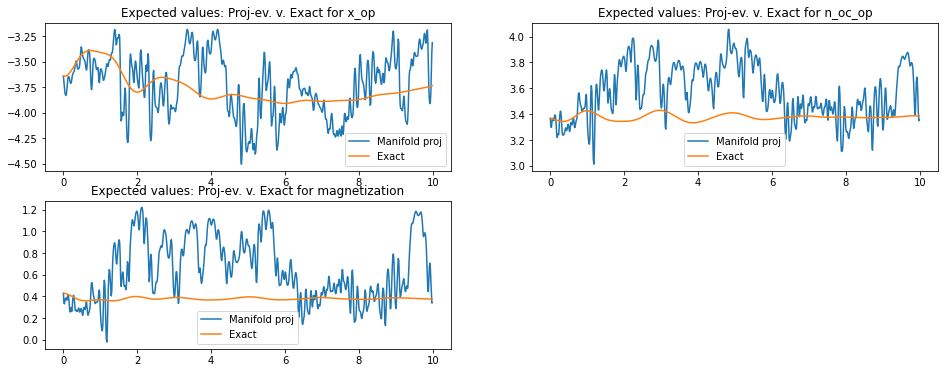

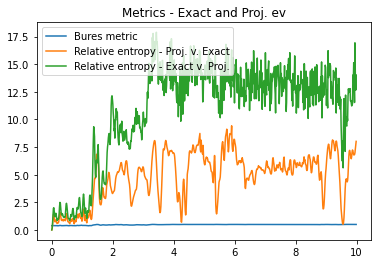

In [7]:
initial_d_list = [0, 50, 5, 5]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H,  
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 0 -th level
-5.3625973198324515e-05
Not mean-normalized operator at 1 -th level
-0.7859396077362002
Not mean-normalized operator at 2 -th level
-2.778268066994105e-19j
Not mean-normalized operator at 3 -th level
-0.6183687885149934
The 3 -th operator is not normalized 

Not mean-normalized operator at 4 -th level
-4.828087799349512e-20j
Not mean-normalized operator at 6 -th level
7.623296525288703e-21j
Not mean-normalized operator at 8 -th level
-4.277516383634217e-20j
Not mean-normalized operator at 10 -th level
-1.8211208365967457e-20j
Not mean-normalized operator at 12 -th level
-2.202285662861181e-20j
Not mean-normalized operator at 14 -th level
1.6940658945086007e-20j
Not mean-normalized operator at 16 -th level
-2.879912020664621e-20j
Not mean-normalized operator at 18 -th level
1.0164395367051604e-20j
Not mean-normalized operator at 19 -th level
-2.643054379154611e-05
Not mean-normalized operator at 20 -th level
1.1858461261560205e-20j
Not mean-no

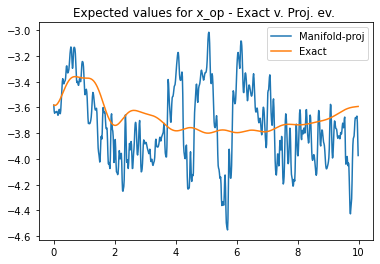

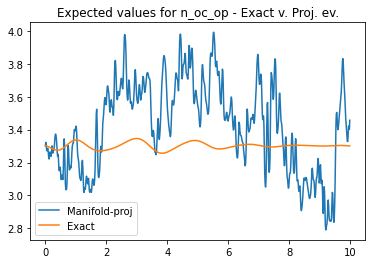

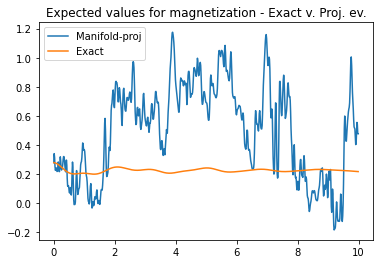

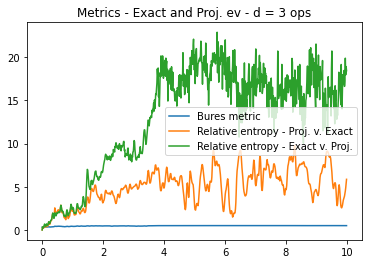

In [5]:
initial_d_list = [0, 30, 30, 15]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations